# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np

In [2]:
from catboost import CatBoostRegressor
import lightgbm

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# Функция построения гистограммы и боксплот
def stat_plot(data, param, bins=10):
    # Create Fig
    fig = plt.figure(figsize=(15, 6), dpi= 80)
    grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

    # Define the axes
    ax_main = fig.add_subplot(grid[:-1, :-1])
    ax_right = fig.add_subplot(grid[:-1, -1])
    
    # histogram on main ax
    ax_main.hist(data[param], bins, histtype='stepfilled', orientation='vertical')

    # boxplot in the right
    ax_right.boxplot(data[param])
    ax_right.grid(axis='y')

    # Decorations
    ax_main.set(title='Гистограмма и боксплот по параметру '+param)

    plt.show()

In [6]:
df = pd.read_csv('/datasets/autos.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Исходный датасет содержит 354369 записей и 16 столбцов. Часть столбцов не имеют отношения к характеристикам автомобиля, а относятся к владельцу или анкете. Удалим такие столбцы из рассмотрения.

In [9]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Датасет содержит 5 столбцов, в части из них содержаться пустые данные. 

#### Для корректного построения моделей необходимо проверить данные на наличие выбросов, заполнить или удалить null-значения, стандартизировать признаки.

Исследуем целевой признак **Price**

Первым шагом построим гистограмму и боксплот 

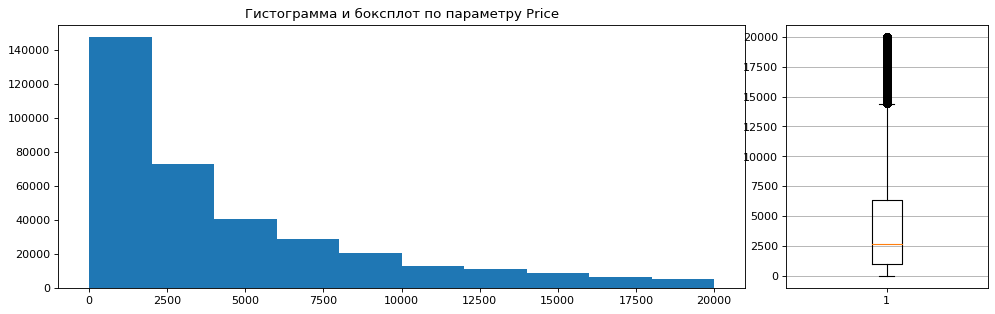

In [11]:
stat_plot(df, 'Price', 10)

На построенных диаграммах, видны выбросы около 15 тыс. евро, так же в данных есть автомобили со стоимостью 0 евро. Рассмотрим эти данные деталей.

Рассчитаем количество автомобилей с ценой равной 0.

In [12]:
df.loc[df['Price'] == 0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN
111,0,NaN,2017,manual,0,golf,5000,petrol,volkswagen,NaN
115,0,small,1999,NaN,0,NaN,5000,petrol,volkswagen,NaN
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354205,0,NaN,2000,manual,65,corsa,150000,NaN,opel,yes
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,NaN
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,NaN
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


Записей содержащих 0 в столбце **Price** около 11 тысяч, что составляет 3% всех записей. Возможно при создании объявления владелец автомобиля по ошибке не указал стоимость, или такая ситуация возникла из-за ошибки сервиса. Так как нас интересует рыночная стоимость автомобиля, то заполним данные значения средней стоимостью на основании значений столбцов **Brand**, **Model**, **RegistrationYear**.

Предварительно проработаем null-значения и проверим корректность данных в указанных выше столбцах.

Рассмотрим столбец **RegistrationYear**

Проверим корректность данных содержащихся в данном столбце.

In [13]:
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

В столбце **RegistrationYear** явно содержаться некорректные данные, машины с годом регистрации ранее 1900 года и позднее 2020. Рассчитаем количество таких данных.

In [14]:
df.loc[(df['RegistrationYear'] < 1900) | (df['RegistrationYear'] > 2020), 'RegistrationYear'].count()

171

Столбец **RegistrationYear** содержит 171 некорректную запись, это менее 1%. Возможность восстановить данные отсутствует, поэтому удалим их.

In [15]:
df = df.loc[(df['RegistrationYear'] >= 1900) & (df['RegistrationYear'] <= 2020)]

In [16]:
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1960, 1966, 1975, 1963, 1964, 1954, 1958, 1967, 1959, 1956,
       1941, 1962, 1929, 1957, 1940, 1949, 2019, 1937, 1951, 1953, 1933,
       1950, 1948, 1952, 1932, 1942, 1935, 1936, 1923, 1930, 1944, 1943,
       1934, 1938, 1928, 1919, 1931, 1915, 1920, 1947, 1927, 1946])

In [17]:
df.loc[(df['RegistrationYear'] < 1900) | (df['RegistrationYear'] > 2020), 'RegistrationYear'].count()

0

Некорректные данные в столбце **RegistrationYear** отсутствуют.

Рассмотрим столбцы **VehicleType**, **Model** и **Brand**

In [18]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [19]:
df['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [20]:
df['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [21]:
df['VehicleType'].isnull().sum()

37319

In [22]:
df['Model'].isnull().sum()

19630

In [23]:
df['Brand'].isnull().sum()

0

В столбце **Brand** пустые значения отсутствуют,  в столбцах **Model** и **VehicleType** содержится 5.5% и 10% пустых строк соответственно. Заполним столбец **VehicleType** на основании столбцов **Brand** и **Model** там где это возможно.

Создадим сводную модель по всем брендам, моделям и типам кузова.

In [24]:
df_pivot_vehicletype = pd.pivot_table(df, values='Price', index=['Brand', 'Model'],
                    columns=['VehicleType'], aggfunc=['count'], fill_value=0)

In [25]:
df_pivot_vehicletype = df_pivot_vehicletype.reset_index()

In [26]:
df_pivot_vehicletype.columns = ['Brand', 'Model', 'bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']

In [27]:
df_pivot_vehicletype

,Brand,Model,bus,convertible,coupe,other,sedan,small,suv,wagon
0,alfa_romeo,145,0,0,2,1,13,19,0,0
1,alfa_romeo,147,0,0,27,7,358,97,1,2
2,alfa_romeo,156,0,0,3,1,287,2,0,288
3,alfa_romeo,159,0,0,0,0,55,0,0,145
4,alfa_romeo,other,0,1,180,5,190,114,0,6
...,...,...,...,...,...,...,...,...,...,...
292,volvo,v40,0,0,0,1,17,0,0,689
293,volvo,v50,0,0,0,0,1,0,0,243
294,volvo,v60,0,0,0,0,3,0,0,38
295,volvo,v70,0,0,1,0,0,0,0,608


Напишем функцию, которая на основании значений в столбцах **Brand** и **Model** будет определять тип кузова из сводной таблицы **df_pivot_vehicletype**

In [28]:
def vehicletype(row):
    brand = row['Brand']
    model = row['Model']
    vehicletype = df_pivot_vehicletype.loc[(df_pivot_vehicletype['Brand'] == brand) & (df_pivot_vehicletype['Model'] == model), 
                      ['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']].idxmax(axis=1).values[0]
    return vehicletype

In [29]:
df.loc[((df['VehicleType'].isnull()) & (df['Model'].notnull())), ['VehicleType']] = df.loc[(df['VehicleType'].isnull()) & (df['Model'].notnull())].apply(vehicletype, axis=1)

In [30]:
df['VehicleType'].isnull().sum()

6753

В столбце **VehicleType** 2% пустых записей, восстановить оставшиеся пустые значения нет возможности, поэтому удалим их.

Теперь количество пустых записей в столбце **Model** больше, чем записей в столбце **VehicleType**. Это означает, что есть записи, для которых заполнены значения **Brand** и **VehicleType**, и не заполнено значение **Model**. Создадим функцию аналогичную функции *vehicletype*, но для определения модели автомобиля.

In [31]:
def model(row):
    brand = row['Brand']
    vehicletype = row['VehicleType']
    if brand == 'sonstige_autos':
        return None
    else:
        id_max_model = df_pivot_vehicletype.loc[(df_pivot_vehicletype['Brand'] == brand), vehicletype].idxmax()
        model = df_pivot_vehicletype.loc[id_max_model,'Model']
        return model

In [32]:
df.loc[((df['VehicleType'].notnull()) & (df['Model'].isnull())), ['Model']] = df.loc[(df['VehicleType'].notnull()) & (df['Model'].isnull())].apply(model, axis=1)

In [33]:
df['Model'].isnull().sum()

9086

После применения функции *model*, записей с пустым значением **Model** осталось около 2,5%. Что все равно не равно кличеству пустых значений в столбце **VehicleType**. Проверим записи, для которых пустое значение столбца **Model** и не пустое значение столбца **VehicleType**.

In [34]:
df.loc[df['Model'].isnull() & df['VehicleType'].notnull(), 'Brand'].unique()

array(['sonstige_autos'], dtype=object)

Всего таких записей 2333 и все они относятся к бренду *sonstige_autos*, данное название используется для автомобилей, которые не относятся ни к одному из перечисленных в поле **Brand** бренду. Поэтому заполним поле **Model** значеннием sonstige_models.

In [35]:
df.loc[df['Brand'] == 'sonstige_autos', 'Model'].unique()

array([None, nan], dtype=object)

In [36]:
df.loc[df['Brand'] == 'sonstige_autos', 'Model'] = 'sonstige_models'

Проверяем корректность заполнения поля **Model**

In [37]:
df.loc[df['Brand'] == 'sonstige_autos']

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
59,1,suv,1994,manual,286,sonstige_models,150000,NaN,sonstige_autos,NaN
306,200,NaN,2009,NaN,0,sonstige_models,10000,NaN,sonstige_autos,NaN
431,3950,small,2004,auto,5,sonstige_models,70000,gasoline,sonstige_autos,no
650,15000,coupe,1971,NaN,0,sonstige_models,5000,NaN,sonstige_autos,no
661,9900,suv,2000,auto,250,sonstige_models,150000,lpg,sonstige_autos,no
...,...,...,...,...,...,...,...,...,...,...
354062,6000,small,2008,manual,155,sonstige_models,150000,petrol,sonstige_autos,no
354073,1750,NaN,1995,NaN,0,sonstige_models,100000,NaN,sonstige_autos,NaN
354083,0,NaN,2000,NaN,0,sonstige_models,150000,NaN,sonstige_autos,NaN
354321,9400,wagon,2007,manual,200,sonstige_models,150000,gasoline,sonstige_autos,yes


In [38]:
df['Model'].isnull().sum()

5748

Создадим отдельный датасет, в котором удалим строки с null-значениями в столбце **VehicleType**

In [39]:
df_autotype_full = df.loc[df['VehicleType'].notnull()]

In [40]:
df_autotype_full = df_autotype_full.reset_index()

In [41]:
df_autotype_full = df_autotype_full.drop('index', axis=1)

In [42]:
df_autotype_full.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,tt,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


В новом датасете в столбцах **VehicleType** и **Model** пустые значения отсутствуют.

Рассмотрим столбец **NotRepaired**

In [43]:
df_autotype_full['NotRepaired'].isnull().sum()

66595

Столбец **NotRepaired** содержит 19% пустых значений. Воспользуемся моделью решающего дерева для прогнозировани значения столбца **NotRepaired**. Предварительно проведем порядковое кодирование для категориальных переменных, для которых отсутствуют пустые значения.

In [44]:
df_autotype_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347445 entries, 0 to 347444
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             347445 non-null  int64 
 1   VehicleType       347445 non-null  object
 2   RegistrationYear  347445 non-null  int64 
 3   Gearbox           330695 non-null  object
 4   Power             347445 non-null  int64 
 5   Model             347445 non-null  object
 6   Kilometer         347445 non-null  int64 
 7   FuelType          318930 non-null  object
 8   Brand             347445 non-null  object
 9   NotRepaired       280850 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.5+ MB


Используем прямое кодирование для столбцов **VehicleType**, **Model**, **Brand**

In [45]:
encoder = OrdinalEncoder()
df_autotype_full_ordinal = pd.DataFrame(encoder.fit_transform(df_autotype_full.loc[:, ['VehicleType', 'Model', 'Brand']]),
                            columns=['VehicleType', 'Model', 'Brand'])

In [46]:
df_autotype_full_ordinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347445 entries, 0 to 347444
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   VehicleType  347445 non-null  float64
 1   Model        347445 non-null  float64
 2   Brand        347445 non-null  float64
dtypes: float64(3)
memory usage: 8.0 MB


Заменим категории в датафрейме **df_autotype_full** на категории содержащиеся в датафрейме **df_autotype_full_ordinal**

In [47]:
df_autotype_full = df_autotype_full.copy()

In [48]:
df_autotype_full['VehicleType'] = df_autotype_full_ordinal['VehicleType']

In [49]:
df_autotype_full['Model'] = df_autotype_full_ordinal['Model']

In [50]:
df_autotype_full['Brand'] = df_autotype_full_ordinal['Brand']

In [51]:
df_autotype_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347445 entries, 0 to 347444
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             347445 non-null  int64  
 1   VehicleType       347445 non-null  float64
 2   RegistrationYear  347445 non-null  int64  
 3   Gearbox           330695 non-null  object 
 4   Power             347445 non-null  int64  
 5   Model             347445 non-null  float64
 6   Kilometer         347445 non-null  int64  
 7   FuelType          318930 non-null  object 
 8   Brand             347445 non-null  float64
 9   NotRepaired       280850 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 26.5+ MB


Столбцы содержащие пустые значения закодируем вручную

In [52]:
df_autotype_full['NotRepaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [53]:
df_autotype_full.loc[df_autotype_full['NotRepaired'] == 'yes', 'NotRepaired'] = 1

In [54]:
df_autotype_full.loc[df_autotype_full['NotRepaired'] == 'no', 'NotRepaired'] = 0

In [55]:
df_autotype_full['NotRepaired'].unique()

array([nan, 1, 0], dtype=object)

In [56]:
df_autotype_full['Gearbox'].value_counts()

manual    265063
auto       65632
Name: Gearbox, dtype: int64

In [57]:
df_autotype_full.loc[df_autotype_full['Gearbox'] == 'auto', 'Gearbox'] = 1

In [58]:
df_autotype_full.loc[df_autotype_full['Gearbox'] == 'manual', 'Gearbox'] = 0

In [59]:
df_autotype_full['Gearbox'].value_counts()

0    265063
1     65632
Name: Gearbox, dtype: int64

In [60]:
df_autotype_full['FuelType'].value_counts()

petrol      214525
gasoline     98080
lpg           5262
cng            556
hybrid         232
other          186
electric        89
Name: FuelType, dtype: int64

In [61]:
df_autotype_full.loc[df_autotype_full['FuelType'] == 'petrol', 'FuelType'] = 1

In [62]:
df_autotype_full.loc[df_autotype_full['FuelType'] == 'gasoline', 'FuelType'] = 1

In [63]:
df_autotype_full.loc[df_autotype_full['FuelType'] == 'lpg', 'FuelType'] = 2

In [64]:
df_autotype_full.loc[df_autotype_full['FuelType'] == 'other', 'FuelType'] = 2

In [65]:
df_autotype_full.loc[df_autotype_full['FuelType'] == 'cng', 'FuelType'] = 2

In [66]:
df_autotype_full.loc[df_autotype_full['FuelType'] == 'electric', 'FuelType'] = 2

In [67]:
df_autotype_full.loc[df_autotype_full['FuelType'] == 'hybrid', 'FuelType'] = 2

In [68]:
df_autotype_full['FuelType'].value_counts()

1    312605
2      6325
Name: FuelType, dtype: int64

In [69]:
df_autotype_full.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,4.0,1993,0,0,116.0,150000,1,38.0,NaN
1,18300,2.0,2011,0,190,226.0,125000,1,1.0,1
2,9800,6.0,2004,1,163,117.0,125000,1,14.0,NaN
3,1500,5.0,2001,0,75,116.0,150000,1,38.0,0
4,3600,5.0,2008,0,69,101.0,90000,1,31.0,0


In [70]:
df_autotype_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347445 entries, 0 to 347444
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             347445 non-null  int64  
 1   VehicleType       347445 non-null  float64
 2   RegistrationYear  347445 non-null  int64  
 3   Gearbox           330695 non-null  object 
 4   Power             347445 non-null  int64  
 5   Model             347445 non-null  float64
 6   Kilometer         347445 non-null  int64  
 7   FuelType          318930 non-null  object 
 8   Brand             347445 non-null  float64
 9   NotRepaired       280850 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 26.5+ MB


In [71]:
target = df_autotype_full.loc[(df_autotype_full['NotRepaired'].notnull() & 
                               df_autotype_full['Gearbox'].notnull() & 
                               df_autotype_full['FuelType'].notnull()), 'NotRepaired']
target=target.astype('int')
features = df_autotype_full.loc[(df_autotype_full['NotRepaired'].notnull() & 
                                 df_autotype_full['Gearbox'].notnull() & 
                                 df_autotype_full['FuelType'].notnull())].drop('NotRepaired', axis=1)

In [72]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [73]:
numeric = ['Price', 'Power']

scaler = StandardScaler()

scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [74]:
features_train.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand
234062,-0.593193,5.0,2005,0,-0.371774,102.0,125000,1,10.0
42303,-0.720752,7.0,2001,0,-0.019203,3.0,150000,1,0.0
160098,-0.944194,4.0,1984,0,0.018573,95.0,150000,1,20.0
13297,-0.178624,1.0,2004,0,0.005981,149.0,150000,1,27.0
143617,1.649732,2.0,2009,1,0.194858,76.0,125000,1,20.0


Обучим модель

In [75]:
model = DecisionTreeClassifier(random_state=12345, max_depth=10, min_samples_leaf=2,
                               class_weight='balanced')
model.fit(features_train, target_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

Протестируем модель и рассчитаем метрику AUC-ROC

In [76]:
predicted_test = model.predict(features_test)

In [77]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
auc_roc

0.8050277897855534

Проверим, что модель лучше, чем случайная.

In [78]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=12345)
dummy_clf.fit(features_test, target_test)
probabilities_clf = dummy_clf.predict_proba(features_test)

In [79]:
probabilities_one_clf = probabilities_clf[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_clf)
auc_roc

0.5

Метрика AUC-ROC обученной модели лучше, чем случайной, ее можно использовать для заполнения null-значений в столбце **NotRepaired**

Заполним пустые значения столбца **NotRepaired**.

In [80]:
df_autotype_full.loc[(df_autotype_full['NotRepaired'].isnull() & 
                      df_autotype_full['Gearbox'].notnull() & 
                      df_autotype_full['FuelType'].notnull()), 
                     'NotRepaired'] = model.predict(df_autotype_full.loc[(df_autotype_full['NotRepaired'].isnull() & 
                                                                          df_autotype_full['Gearbox'].notnull() & 
                                                                          df_autotype_full['FuelType'].notnull()), 
                                                                         ['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 
                                                                          'Model', 'Kilometer', 'FuelType', 'Brand']])

In [81]:
df_autotype_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347445 entries, 0 to 347444
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             347445 non-null  int64  
 1   VehicleType       347445 non-null  float64
 2   RegistrationYear  347445 non-null  int64  
 3   Gearbox           330695 non-null  object 
 4   Power             347445 non-null  int64  
 5   Model             347445 non-null  float64
 6   Kilometer         347445 non-null  int64  
 7   FuelType          318930 non-null  object 
 8   Brand             347445 non-null  float64
 9   NotRepaired       329102 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 26.5+ MB


In [82]:
df_autotype_full['NotRepaired'].isnull().sum()

18343

В столбце **NotRepaired** осталось 5% пустых записей, удалим их.

In [83]:
df_autotype_full = df_autotype_full.copy()

In [84]:
df_autotype_full = df_autotype_full.loc[df_autotype_full['NotRepaired'].notnull()]
df_autotype_full = df_autotype_full.reset_index()
df_autotype_full = df_autotype_full.drop('index', axis=1)

In [85]:
df_autotype_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329102 entries, 0 to 329101
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             329102 non-null  int64  
 1   VehicleType       329102 non-null  float64
 2   RegistrationYear  329102 non-null  int64  
 3   Gearbox           322392 non-null  object 
 4   Power             329102 non-null  int64  
 5   Model             329102 non-null  float64
 6   Kilometer         329102 non-null  int64  
 7   FuelType          314020 non-null  object 
 8   Brand             329102 non-null  float64
 9   NotRepaired       329102 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 25.1+ MB


Пустые значения остались в столбцах **Gearbox** и **FuelType**, 2% и 5% соответсвенно. Эти данные нет возможности восстановить, поэтому пустые данные в данных столбцах удалим.

In [86]:
df_full = df_autotype_full.loc[df_autotype_full['Gearbox'].notnull()]
df_full = df_full.loc[df_full['FuelType'].notnull()]
df_full = df_full.reset_index(drop=True)

In [87]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308652 entries, 0 to 308651
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             308652 non-null  int64  
 1   VehicleType       308652 non-null  float64
 2   RegistrationYear  308652 non-null  int64  
 3   Gearbox           308652 non-null  object 
 4   Power             308652 non-null  int64  
 5   Model             308652 non-null  float64
 6   Kilometer         308652 non-null  int64  
 7   FuelType          308652 non-null  object 
 8   Brand             308652 non-null  float64
 9   NotRepaired       308652 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 23.5+ MB


Заполним нулевые значения в столбцах **Price** и **Power** средними значениями.

In [88]:
df_full_pivot = pd.pivot_table(df_full, values='Price', index=['Brand', 'Model'], columns='RegistrationYear', 
               aggfunc=['mean'], fill_value=0)

In [89]:
df_full_pivot = df_full_pivot.reset_index()

In [90]:
df_full_pivot.columns = ['Brand', 'Model', 1910, 1919, 1923, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934,
                                  1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1950, 1951,
                                  1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 
                                  1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 
                                  1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 
                                  1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 
                                  2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

In [91]:
df_full_pivot.head()

,Brand,Model,1910,1919,1923,1927,1928,1929,1930,1931,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,0.0,1.0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,125.000000,599.0000,0.000000,0
1,0.0,2.0,0,0,0,0,0,0,0,0,...,6240.222222,13950.000000,0.0,0.000000,0.0,0.0,1692.947368,1993.6875,2263.166667,0
2,0.0,3.0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.000000,0.0,4150.0,808.333333,800.0000,1600.000000,1200
3,0.0,4.0,0,0,0,0,0,0,0,0,...,12040.384615,12096.666667,14999.0,0.000000,0.0,0.0,0.000000,9750.0000,0.000000,0
4,0.0,166.0,0,0,0,0,0,0,0,0,...,8947.555556,9904.897959,12044.9,15671.428571,15299.9,16333.0,500.000000,13950.0000,0.000000,0


In [92]:
def price(row):
    brand = row['Brand']
    model = row['Model']
    regyear = row['RegistrationYear']
    price = df_full_pivot.loc[(df_full_pivot['Brand'] == brand) & 
                              (df_full_pivot['Model'] == model), regyear].values[0]
    return price

Заполним значения цены 0 на среднюю стоимость автомобиля в соответствии с брендом, моделью и годом регистрации.

In [93]:
df_full.loc[df_full['Price'] == 0, 'Price'] = df_full.loc[df_full['Price'] == 0].apply(price, axis=1)

Проверим количество строк с параметром **Price** равным 0.

In [94]:
df_full.loc[df_full['Price'] == 0, 'Price'].count()

78

Осталось 78 строк с ценой равной 0.

Рассмотрим столбец **Power**

Построим распределение и боксплот.

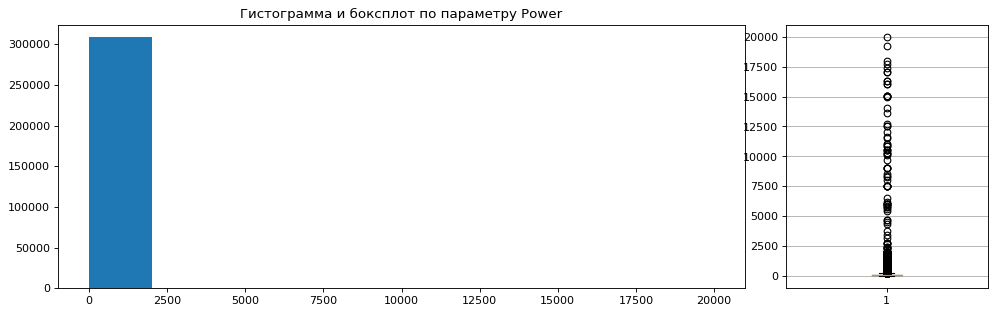

In [95]:
stat_plot(df_full, 'Power', 10)

Столбец **Power** содержит явно некорректные данные количество л.с. = 0 и свыше 500. Рассчитаем количество таких автомобилей.

In [96]:
df_full.loc[df_full['Power']==0, 'Power'].count()

21720

In [97]:
df_full.loc[df_full['Power']>=500, 'Power'].count()

370

Удалим из датасета данные о автомобилях с л.с. свыше 500, таких записей 370.

In [98]:
df_full = df_full.loc[df_full['Power']<500].reset_index(drop=True)

Для записей с параметром **Power** равным 0 напишем функцию для вычисления среднего значения количества л.с. в зависимости от бренда, модели и года регистрации.

In [99]:
df_full_power_pivot = pd.pivot_table(df_full, values='Power', index=['Brand', 'Model'], columns='RegistrationYear', 
               aggfunc=['mean'], fill_value=0)

In [100]:
df_full_power_pivot = df_full_power_pivot.reset_index()

In [101]:
df_full_power_pivot.columns = ['Brand', 'Model', 1910, 1919, 1923, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934,
                                  1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1950, 1951,
                                  1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 
                                  1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 
                                  1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 
                                  1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 
                                  2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

In [102]:
df_full_power_pivot.head()

,Brand,Model,1910,1919,1923,1927,1928,1929,1930,1931,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,0.0,1.0,0,0,0.0,0,0,0.0,0,0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,103.000000,103.0,0.000000,0
1,0.0,2.0,240,0,0.0,0,0,0.0,0,0,...,93.333333,140.000000,0.0,0.000000,0.0,0.000000,89.842105,97.5,115.333333,0
2,0.0,3.0,0,0,0.0,0,0,0.0,0,0,...,0.000000,0.000000,0.0,0.000000,0.0,116.000000,115.555556,90.0,0.000000,140
3,0.0,4.0,0,0,0.0,0,0,0.0,0,0,...,176.923077,163.666667,170.0,0.000000,0.0,0.000000,0.000000,177.5,0.000000,0
4,0.0,166.0,0,0,0.0,0,0,0.0,0,0,...,119.851852,125.000000,150.5,139.285714,138.7,136.666667,0.000000,117.5,0.000000,0


In [103]:
def power(row):
    brand = row['Brand']
    model = row['Model']
    regyear = row['RegistrationYear']
    power = df_full_power_pivot.loc[(df_full_power_pivot['Brand'] == brand) & 
                                    (df_full_power_pivot['Model'] == model), regyear].values[0]
    return power

In [104]:
df_full.loc[df_full['Power'] == 0, 'Power'] = df_full.loc[df_full['Power'] == 0].apply(power, axis=1)

In [105]:
df_full.loc[df_full['Power']==0, 'Power'].count()

299

Осталось 299 строк с мощьностью равной 0.

In [106]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308282 entries, 0 to 308281
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             308282 non-null  float64
 1   VehicleType       308282 non-null  float64
 2   RegistrationYear  308282 non-null  int64  
 3   Gearbox           308282 non-null  object 
 4   Power             308282 non-null  float64
 5   Model             308282 non-null  float64
 6   Kilometer         308282 non-null  int64  
 7   FuelType          308282 non-null  object 
 8   Brand             308282 non-null  float64
 9   NotRepaired       308282 non-null  object 
dtypes: float64(5), int64(2), object(3)
memory usage: 23.5+ MB


Для корректной работы моделей, переведем все категориальные признаки в тип int.

In [107]:
df_full = df_full.astype({'VehicleType': 'int64',
                         'Gearbox': 'int64',
                         'Model': 'int64',
                         'Kilometer': 'int64',
                         'FuelType': 'int64',
                         'Brand': 'int64',
                         'NotRepaired': 'int64'})

In [108]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308282 entries, 0 to 308281
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             308282 non-null  float64
 1   VehicleType       308282 non-null  int64  
 2   RegistrationYear  308282 non-null  int64  
 3   Gearbox           308282 non-null  int64  
 4   Power             308282 non-null  float64
 5   Model             308282 non-null  int64  
 6   Kilometer         308282 non-null  int64  
 7   FuelType          308282 non-null  int64  
 8   Brand             308282 non-null  int64  
 9   NotRepaired       308282 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 23.5 MB


### В ходе подготовки данных были удалены или заполнены null-значения в столбцах VehicleType, Gearbox, Model, FuelType, NotRepaired. В столбцах RegistrationYear, Price, Power были удалены или исправлены некорректные значения. Также были перекодированны категориальные признаки. Масштабирование признаков не требуется, так как в признаках только один количественный параметр Количество л.с. (Power).

# 3. Анализ моделей

Разобьем датасет на обучающую и тестовую выборки

In [109]:
target = df_full['Price']
features = df_full.drop(['Price'], axis=1)

In [110]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.25, random_state=12345)

### Обучение модели CatBoost

Обучаем модель CatBoostRegressor

In [111]:
model_cbr = CatBoostRegressor()

In [112]:
cat_features = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 'Kilometer', 'FuelType', 'Brand', 'NotRepaired']

Задаем сетку гиперпараметров

In [113]:
%%time
grid = {'learning_rate': [0.01, 0.1, 0.5],
        'depth': [4, 8, 12],
        'iterations': [100, 500, 1000],
        'l2_leaf_reg': [1, 5, 9]}

grid_search_result = model_cbr.grid_search(grid, 
                                       X=features_train, 
                                       y=target_train,
                                       cv = 3)

0:	loss: 3455.8359016	best: 3455.8359016 (0)	total: 13.8s	remaining: 18m 25s
1:	loss: 1936.9454408	best: 1936.9454408 (1)	total: 24.2s	remaining: 15m 56s
2:	loss: 1779.2580140	best: 1779.2580140 (2)	total: 34.7s	remaining: 15m 2s
3:	loss: 3457.1798448	best: 1779.2580140 (2)	total: 45.4s	remaining: 14m 33s
4:	loss: 1940.4330318	best: 1779.2580140 (2)	total: 55.7s	remaining: 14m 6s
5:	loss: 1778.6965851	best: 1778.6965851 (5)	total: 1m 6s	remaining: 13m 47s
6:	loss: 3455.2902041	best: 1778.6965851 (5)	total: 1m 16s	remaining: 13m 31s
7:	loss: 1937.8559502	best: 1778.6965851 (5)	total: 1m 27s	remaining: 13m 21s
8:	loss: 1790.7822830	best: 1778.6965851 (5)	total: 1m 38s	remaining: 13m 4s
9:	loss: 2103.2676586	best: 1778.6965851 (5)	total: 2m 31s	remaining: 17m 58s
10:	loss: 1759.3692611	best: 1759.3692611 (10)	total: 3m 23s	remaining: 21m 33s
11:	loss: 1675.0012402	best: 1675.0012402 (11)	total: 4m 15s	remaining: 24m 27s
12:	loss: 2103.8337117	best: 1675.0012402 (11)	total: 5m 7s	remaining

In [114]:
model_cbr.get_best_score()

{'learn': {'RMSE': 1259.4288500802706}}

In [115]:
model_cbr.get_params()

{'loss_function': 'RMSE',
 'depth': 12,
 'l2_leaf_reg': 1,
 'iterations': 1000,
 'learning_rate': 0.1}

Лучшая оценка RMSE для модели CatBoost - 1259.43, лучшие гиперпараметры:
* depth: 12
* l2_leaf_reg: 1
* iterations: 1000
* learning_rate: 0.1  

Время обучения 2 часа 44 минуты.

Рассчитаем качество модели на тестовой выборке

In [116]:
from sklearn.metrics import mean_squared_error

In [117]:
predicted_test_cbr = model_cbr.predict(features_test)

In [118]:
mse = mean_squared_error(target_test, predicted_test_cbr)

In [119]:
RMSE = mse**0.5
RMSE

1571.001442564717

RMSE на тестовой выборке получилось 1571.0.

### Обучение модели LightGBM 

In [120]:
model_lgbm = lightgbm.LGBMRegressor()

In [121]:
cat_features = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 'Kilometer', 'FuelType', 'Brand', 'NotRepaired']

In [132]:
param_grid = {'learning_rate': [0.01, 0.1, 0.5],
              'max_depth': [4, 8, 12],
              'n_estimators': [100, 200 , 300],
              'num_leaves': [16, 64, 144]}

In [133]:
from sklearn.metrics import make_scorer

In [134]:
# Функция расчета RMSE
def RMSE(target, predict):
    mse = mean_squared_error(target, predict)
    RMSE = mse**0.5
    return RMSE

In [135]:
scorer = make_scorer(score_func = RMSE, greater_is_better = False)

In [136]:
grid = GridSearchCV(model_lgbm, param_grid=param_grid, cv=3, scoring=scorer, verbose = 50)

In [137]:
%%time
grid.fit(features_train, target_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, num_leaves=16 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, num_leaves=16, score=-2801.507, total= 3.7min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, num_leaves=16 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, num_leaves=16, score=-2798.697, total= 2.3min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.0min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, num_leaves=16 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, num_leaves=16, score=-2811.469, total=  53.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.9min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, num_leaves=64 
[CV]  learning_rate=0.01

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [4, 8, 12],
                         'n_estimators': [100, 200, 300],
  

In [138]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 300, 'num_leaves': 144}

In [139]:
grid.best_score_

-1597.2421231617209

Лучшая оценка RMSE для модели LightGBM - 1634.76, лучшие гиперпараметры:
* max_depth: 12
* num_leaves: 144
* n_estimators: 300
* learning_rate: 0.1  

Время обучения 3 часа 35 минут.

In [140]:
model_lgbm = lightgbm.LGBMRegressor(learning_rate=0.1, max_depth=12, n_estimators=300, num_leaves=144)

In [141]:
model_lgbm.fit(features_train, target_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=12,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=144, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [142]:
predicted_test_lgbm = model_lgbm.predict(features_test)

In [143]:
mse = mean_squared_error(target_test, predicted_test_lgbm)

In [144]:
RMSE = mse**0.5
RMSE

1591.2985052687084

RMSE на тестовой выборке получилось 1591.29.

#### По скорости обучения, качеству модели на обучающей и тестовой выборке модель CatBoost показала лучший результат, чем модель LightGBM. Проверим полученную модель на адекватность. 

#### Для проверки моделей на адекватность, создадим предсказания равными среднему значению цены.

In [145]:
mean_price = pd.Series(target_train.mean(), index=target_test.index)

In [146]:
mse = mean_squared_error(target_test, mean_price)

In [147]:
RMSE = mse**0.5
RMSE

4579.149192961967

#### Обученная модель CatBoost показала лучший результат, чем константная модель. Результат модели CatBoost RMSE равный 1571.0, у константной модели RMSE равен 4579.1.

### Обученная модель CatBoost может быть использована для определения стоимости автомобиля. Модель CatBoost выигрывает у модели  LightGBM как по качеству и скорости предсказаний, так и по скорости обучения.